[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 50)            11000     
                                                                 
 lstm_7 (LSTM)               (None, 60, 50)            20200     
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 51451 (200.98 KB)
Trainable params: 51451 (200.98 KB)
Non-trainable params: 0 (0.00 Byte)
_______

10/10 [==============================] - 2s 155ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 70/100
10/10 [==============================] - 2s 157ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 71/100
10/10 [==============================] - 2s 156ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 72/100
10/10 [==============================] - 2s 155ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 73/100
10/10 [==============================] - 2s 155ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 74/100
10/10 [==============================] - 2s 159ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 75/100
10/10 [==============================] - 2s 162ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 76/100
10/10 [==============================] - 2s 160ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 77/100
10/10 [==============================] - 2s 160ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 78/100
10/10 [==============================] - 2s 160ms/step - loss: 0.0018 - val_loss: 

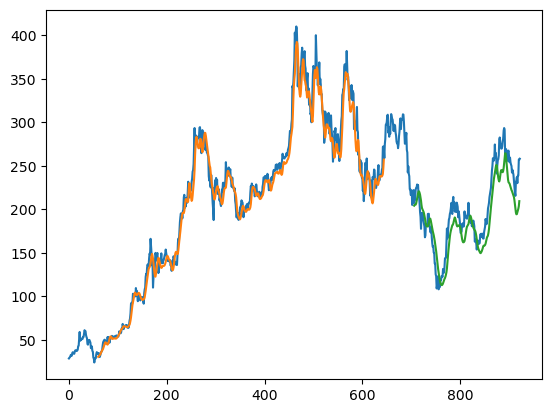

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import time

# get stock data
symbol = "TSLA"
start_date = "2020-01-01"
end_date = "2023-09-01"
data = yf.download(symbol, start=start_date, end=end_date)

# get VIX index
vix_data = yf.download("^VIX", start=start_date, end=end_date)
vix_data = vix_data[['Close']]

# create dataset
tnx_data = yf.download("^TNX", start=start_date, end=end_date)
tnx_data = tnx_data[['Close']]
data = data.join(vix_data, rsuffix='_VIX')
data = data.join(tnx_data, rsuffix='_TNX')
data = data.fillna(method='ffill')
price_volume_vix_tnx_data = data[['Close', 'Volume', 'Close_VIX', 'Close_TNX']].values

# scailing data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(price_volume_vix_tnx_data)

# train test split
train_size = int(len(scaled_data) * 0.7)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

# create input
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 60
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

# build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))  # input layer
model.add(LSTM(50, return_sequences=True))  # hidden layer
model.add(LSTM(50))  # hidden layer
model.add(Dense(1))  # output layer
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

# check the running time
start_time = time.time()

# training model
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=64, verbose=1)

# end to check the time
end_time = time.time()

# print the running time
print("Learning time: ", end_time - start_time, "seconds")

# Make prediction
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# transform to original scale
train_predict = scaler.inverse_transform(np.column_stack((train_predict, np.zeros_like(train_predict), np.zeros_like(train_predict), np.zeros_like(train_predict))))
test_predict = scaler.inverse_transform(np.column_stack((test_predict, np.zeros_like(test_predict), np.zeros_like(test_predict), np.zeros_like(test_predict))))
train_predict = train_predict[:, 0]
test_predict = test_predict[:, 0]

trainY_original = scaler.inverse_transform(np.column_stack((Y_train, np.zeros_like(Y_train), np.zeros_like(Y_train), np.zeros_like(Y_train))))[:, 0]
testY_original = scaler.inverse_transform(np.column_stack((Y_test, np.zeros_like(Y_test), np.zeros_like(Y_test), np.zeros_like(Y_test))))[:, 0]

# get RMSE
print("Train RMSE: ", np.sqrt(mean_squared_error(trainY_original, train_predict)))
print("Test RMSE: ", np.sqrt(mean_squared_error(testY_original, test_predict)))


# plotting
look_back = 60
trainPredictPlot = np.empty_like(price_volume_vix_tnx_data[:, 0])
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back] = train_predict

testPredictPlot = np.empty_like(price_volume_vix_tnx_data[:, 0])
testPredictPlot[:] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2) + 1:len(scaled_data) - 1] = test_predict

plt.plot(scaler.inverse_transform(scaled_data)[:, 0])
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()
